# Example Test OtrisymNMF VS DCBM on political blogs network


The political blogs network is a directed graph of hyperlinks between weblogs on U.S. politics, collected in 2005 by Adamic and Glance. It has highly heterogeneous degrees, which prevents the standard stochastic block model from detecting the correct partition. The blogs were manually labelled by the authors as either liberal or conservative. We treat the network as undirected and retain only the nodes belonging to the largest connected component, which contains 1,222 vertices.


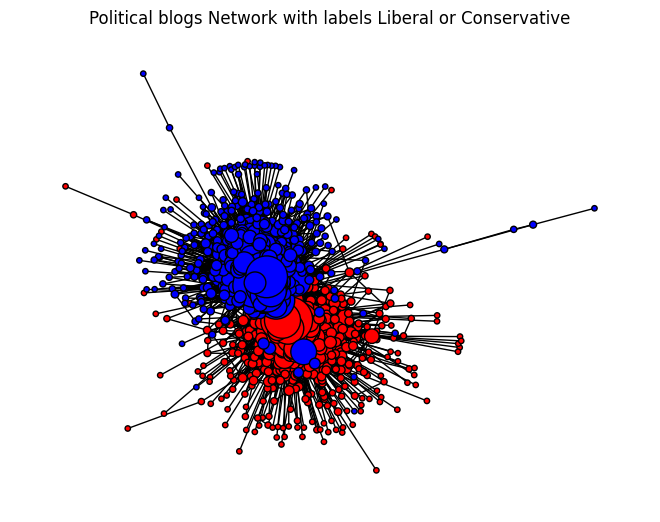

In [4]:
import networkx as nx
import matplotlib.pylab as pl
# Reading the graph
G=nx.read_gml('Data\polblogs_cleaned.gml',label='id')
#Labels
True_partition = [int(G.nodes[node]['value'] )for node in G.nodes]

# Display graph with labels
position = nx.spring_layout(G,seed=14)
node_sizes = [10+G.degree(node) * 5 for node in G]
nx.draw(G, position, node_color=['r' if i == 0 else 'b' for i in True_partition],node_size=node_sizes, edgecolors='black')
pl.title("Political blogs Network with labels Liberal or Conservative")
pl.show()


Let's use the OtrisymNMF factorization of the adjacency matrix of graph X with r = 2 to detect the 2 communities in the network.
- v is a vector that gives the community index for each node.
- w indicates the importance of a node within its community.
- S describes interactions between the r communities.

Running 10 Trials in Series
Trial 1/10 with SSPA in 3 iterations: Error 8.5693e-01 | Best: 8.5693e-01
Trial 2/10 with SVCA in 3 iterations: Error 8.5693e-01 | Best: 8.5693e-01
Trial 3/10 with SVCA in 3 iterations: Error 8.5693e-01 | Best: 8.5693e-01
Trial 4/10 with SVCA in 3 iterations: Error 8.5693e-01 | Best: 8.5693e-01
Trial 5/10 with SVCA in 3 iterations: Error 8.5693e-01 | Best: 8.5693e-01
Trial 6/10 with SVCA in 3 iterations: Error 8.5693e-01 | Best: 8.5693e-01
Trial 7/10 with SVCA in 4 iterations: Error 8.5693e-01 | Best: 8.5693e-01
Trial 8/10 with SVCA in 3 iterations: Error 8.5693e-01 | Best: 8.5693e-01
Trial 9/10 with SVCA in 3 iterations: Error 8.5693e-01 | Best: 8.5693e-01
Trial 10/10 with SVCA in 3 iterations: Error 8.5693e-01 | Best: 8.5693e-01


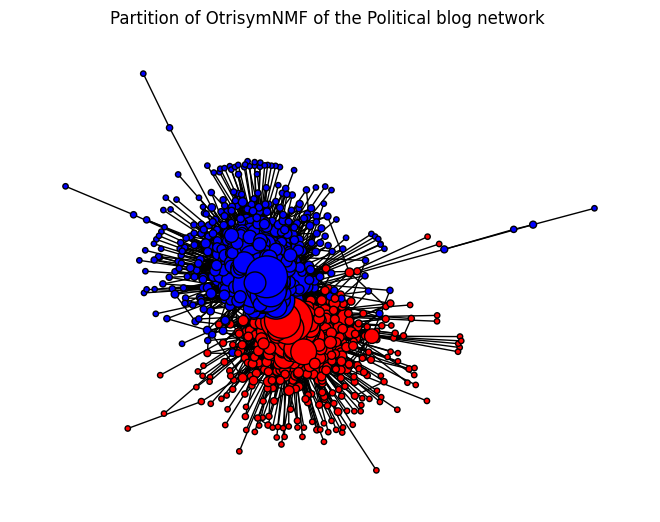

In [11]:
from scipy.sparse import diags
import OtrisymNMF
import numpy as np
np.random.seed(12)

# OtrisymNMF
X = nx.adjacency_matrix(G, nodelist=G.nodes)
w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X, 2,numTrials=10,verbosity=1)

# Display of the OtrisymNMF's partition
position = nx.spring_layout(G,seed=14)
node_sizes = [10+G.degree(node) * 5 for node in G]
nx.draw(G, position, node_color=['r' if i == 0 else 'b' for i in v],node_size=node_sizes, edgecolors='black')
pl.title("Partition of OtrisymNMF of the Political blog network ")
pl.show()

To compare the partition found by OtrisymNMF with the labels, we calculate the NMI.

In [12]:
from sklearn.metrics import normalized_mutual_info_score as NMI
print("NMI score:",NMI(True_partition,v))


NMI score: 0.7223895454752098


Now, let's compare it with the degree-corrected model (DCBM) of Karrer and Newman.

Trial 1/1 with SVCA : logP -3.3381e+05 | Best LogP: -3.3381e+05
Best logP : -333807.2063420393
NMI score: 0.7286769625628147


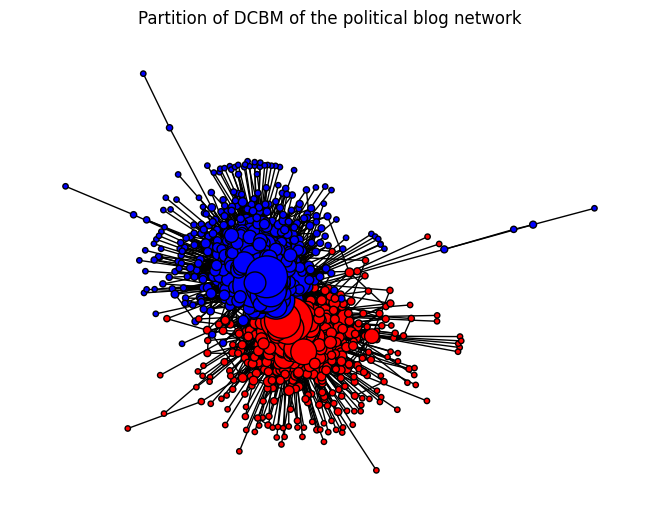

In [13]:
import pysbm
from Utils import DC_BM
import random
random.seed(12)
np.random.seed(40)

#DCBM
DCBM_partition=DC_BM(G,2,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=1,init_method="SVCA")
print("NMI score:",NMI(True_partition,DCBM_partition))

# Change cluster 0 and 1 to have the same indexing
DCBM_partition=[1 - x for x in DCBM_partition]

# Display the partition
nx.draw(G, position, node_color=['r' if i == 0 else 'b' for i in DCBM_partition],node_size=node_sizes, edgecolors='black')
pl.title("Partition of DCBM of the political blog network")
pl.show()

We observe that the partition differs only slightly from the OtrisymNMF's one with a bit higher NMI. Let's see the difference :

In [5]:
nodediff=np.where(DCBM_partition!=v)[0]
print(f"Number of nodes classified differently between OtrisymNMF and DCBM :{len(nodediff)}")
v[nodediff]
print(f"Number of nodes well classified by OtrisymNMF and not by DCBM :{np.sum((v[nodediff] == np.array(True_partition)[nodediff]))}")
print(f"Number of nodes well classified by DCBM and not by OtrisymNMF :{np.sum((np.array(DCBM_partition)[nodediff] == np.array(True_partition)[nodediff]))}")

Number of nodes classified differently between OtrisymNMF and DCBM :568
Number of nodes well classified by OtrisymNMF and not by DCBM :19
Number of nodes well classified by DCBM and not by OtrisymNMF :549
